# NLTK.VADER_LEXICON

In [1]:
import pandas as pd

df = pd.read_csv("chatgpt_reddit - Complete.csv")
df.head(5)

,Post ID,Post author,Post title,Post URL,Post flair type,Post score,Post date,Comment ID,Comment author,Comment,Comment score,Comment date
0,13ty988,FunEntersTheChat,A lawyer used ChatGPT for legal filing. The ch...,https://mashable.com/article/chatgpt-lawyer-ma...,Artificial Intelligence,45599,2023-05-28 13:32:38,jlxlcbk,HanaBothWays,TFW you are trying new and interesting ways to...,8919,2023-05-28 13:41:17
1,13ty988,FunEntersTheChat,A lawyer used ChatGPT for legal filing. The ch...,https://mashable.com/article/chatgpt-lawyer-ma...,Artificial Intelligence,45599,2023-05-28 13:32:38,jly9dss,ponzLL,I ask chat gpt for help with software at work ...,2207,2023-05-28 17:07:22
2,13ty988,FunEntersTheChat,A lawyer used ChatGPT for legal filing. The ch...,https://mashable.com/article/chatgpt-lawyer-ma...,Artificial Intelligence,45599,2023-05-28 13:32:38,jlxpxde,KiwiOk6697,Amount of people who thinks ChatGPT is a searc...,4221,2023-05-28 14:30:15
3,13ty988,FunEntersTheChat,A lawyer used ChatGPT for legal filing. The ch...,https://mashable.com/article/chatgpt-lawyer-ma...,Artificial Intelligence,45599,2023-05-28 13:32:38,jlxorpo,Not_Buying,"I’m fine with them using the tool, but how do ...",1850,2023-05-28 14:18:28
4,13ty988,FunEntersTheChat,A lawyer used ChatGPT for legal filing. The ch...,https://mashable.com/article/chatgpt-lawyer-ma...,Artificial Intelligence,45599,2023-05-28 13:32:38,jly1ic2,MithranArkanere,People need to understand ChatGPT doesn't say ...,216,2023-05-28 16:09:30


## Preprocessing

In [2]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import re

def clean_data(review):
    
    no_punc = re.sub(r'[^\w\s]', '', review)
    no_digits = ''.join([i for i in no_punc if not i.isdigit()])
    
    return(no_digits)

df['Post title'] = df['Post title'].apply(clean_data)
df['Comment'] = df['Comment'].apply(clean_data)

In [3]:
stop_words = set(stopwords.words('english'))  # Import english stop words
df['Comment'] = df['Comment'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))  # Remove stop words

## Sentiment analysis

In [4]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()


In [5]:
df['Sentiment'] = ''
for index, row in df.iterrows():
    comment = row['Comment']
    
    # Applica VADER all'attuale commento
    scores = sia.polarity_scores(comment)
    compound_score = scores['compound']
    
    # Assegna un'etichetta di sentiment in base al punteggio compound
    if compound_score > 0:
        sentiment = 'pos'
    elif compound_score < 0:
        sentiment = 'neg'
    else:
        sentiment = 'neu'
    
    # Assegna l'etichetta di sentiment al DataFrame
    df.at[index, 'Sentiment'] = sentiment

# Stampa il DataFrame con le nuove etichette di sentiment
df['Sentiment'].value_counts()

pos    9423
neu    5542
neg    4498
Name: Sentiment, dtype: int64

## Sentiment distribution

In [6]:
sizes = df["Sentiment"].value_counts()
labels = df["Sentiment"].unique()

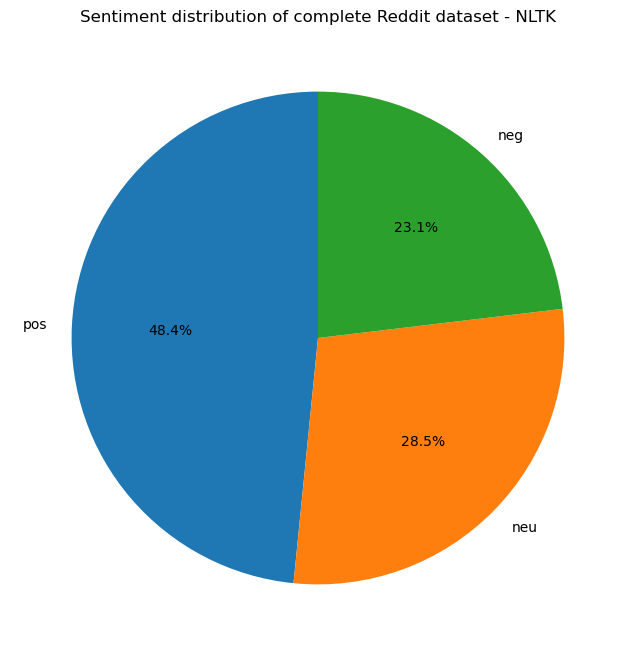

In [7]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 8]

plt.pie(sizes, labels = labels, autopct = '%1.1f%%', shadow = False, startangle = 90)
plt.title("Sentiment distribution of complete Reddit dataset - NLTK")
plt.savefig("pie_nltksentiment-complete.png")
plt.show()

# TextBlob

In [8]:
import pandas as pd

df = pd.read_csv("chatgpt_reddit - Complete.csv")
df.head(5)

,Post ID,Post author,Post title,Post URL,Post flair type,Post score,Post date,Comment ID,Comment author,Comment,Comment score,Comment date
0,13ty988,FunEntersTheChat,A lawyer used ChatGPT for legal filing. The ch...,https://mashable.com/article/chatgpt-lawyer-ma...,Artificial Intelligence,45599,2023-05-28 13:32:38,jlxlcbk,HanaBothWays,TFW you are trying new and interesting ways to...,8919,2023-05-28 13:41:17
1,13ty988,FunEntersTheChat,A lawyer used ChatGPT for legal filing. The ch...,https://mashable.com/article/chatgpt-lawyer-ma...,Artificial Intelligence,45599,2023-05-28 13:32:38,jly9dss,ponzLL,I ask chat gpt for help with software at work ...,2207,2023-05-28 17:07:22
2,13ty988,FunEntersTheChat,A lawyer used ChatGPT for legal filing. The ch...,https://mashable.com/article/chatgpt-lawyer-ma...,Artificial Intelligence,45599,2023-05-28 13:32:38,jlxpxde,KiwiOk6697,Amount of people who thinks ChatGPT is a searc...,4221,2023-05-28 14:30:15
3,13ty988,FunEntersTheChat,A lawyer used ChatGPT for legal filing. The ch...,https://mashable.com/article/chatgpt-lawyer-ma...,Artificial Intelligence,45599,2023-05-28 13:32:38,jlxorpo,Not_Buying,"I’m fine with them using the tool, but how do ...",1850,2023-05-28 14:18:28
4,13ty988,FunEntersTheChat,A lawyer used ChatGPT for legal filing. The ch...,https://mashable.com/article/chatgpt-lawyer-ma...,Artificial Intelligence,45599,2023-05-28 13:32:38,jly1ic2,MithranArkanere,People need to understand ChatGPT doesn't say ...,216,2023-05-28 16:09:30


## Preprocessing

In [9]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import re

def clean_data(review):
    
    no_punc = re.sub(r'[^\w\s]', '', review)
    no_digits = ''.join([i for i in no_punc if not i.isdigit()])
    
    return(no_digits)

df['Post title'] = df['Post title'].apply(clean_data)
df['Comment'] = df['Comment'].apply(clean_data)

In [10]:
stop_words = set(stopwords.words('english'))  # Import english stop words
df['Comment'] = df['Comment'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))  # Remove stop words

## Sentiment analysis

In [11]:
from textblob import TextBlob

# Crea una nuova colonna nel DataFrame per le etichette di sentiment
df['Sentiment'] = ''

# Itera attraverso ogni riga del DataFrame
for index, row in df.iterrows():
    comment = row['Comment']
    
    # Applica l'analisi dei sentimenti di TextBlob all'attuale commento
    blob = TextBlob(comment)
    sentiment = blob.sentiment.polarity
    
    # Assegna un'etichetta di sentiment in base alla polarità
    if sentiment > 0:
        sentiment_label = 'pos'
    elif sentiment < 0:
        sentiment_label = 'neg'
    else:
        sentiment_label = 'neu'
    
    # Assegna l'etichetta di sentiment al DataFrame
    df.at[index, 'Sentiment'] = sentiment_label

# Stampa il DataFrame con le nuove etichette di sentiment
df['Sentiment'].value_counts()

pos    8774
neu    6870
neg    3819
Name: Sentiment, dtype: int64

## Sentiment distribution

In [12]:
sizes = df["Sentiment"].value_counts()
labels = df["Sentiment"].unique()

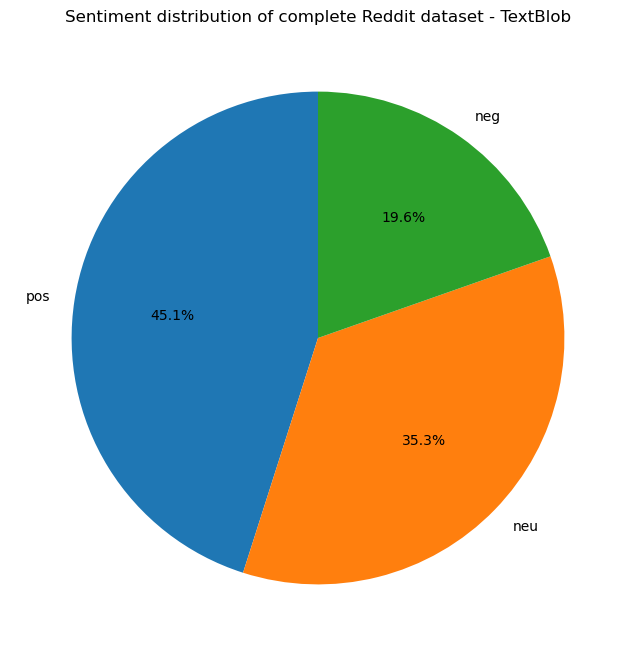

In [13]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 8]

plt.pie(sizes, labels = labels, autopct = '%1.1f%%', shadow = False, startangle = 90)
plt.title("Sentiment distribution of complete Reddit dataset - TextBlob")
plt.savefig("pie_textblobsentiment-complete.png")
plt.show()